In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import random
from PIL import Image
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET

import torch 
import torchvision

In [2]:
import os
print(os.listdir("data"))

['annotati.xml', 'annotations.xml', 'Images']


In [3]:
img_base_path = "data/images"
# Files
images = os.listdir(img_base_path)
print("Number of Images: ", len(images))

Number of Images:  3


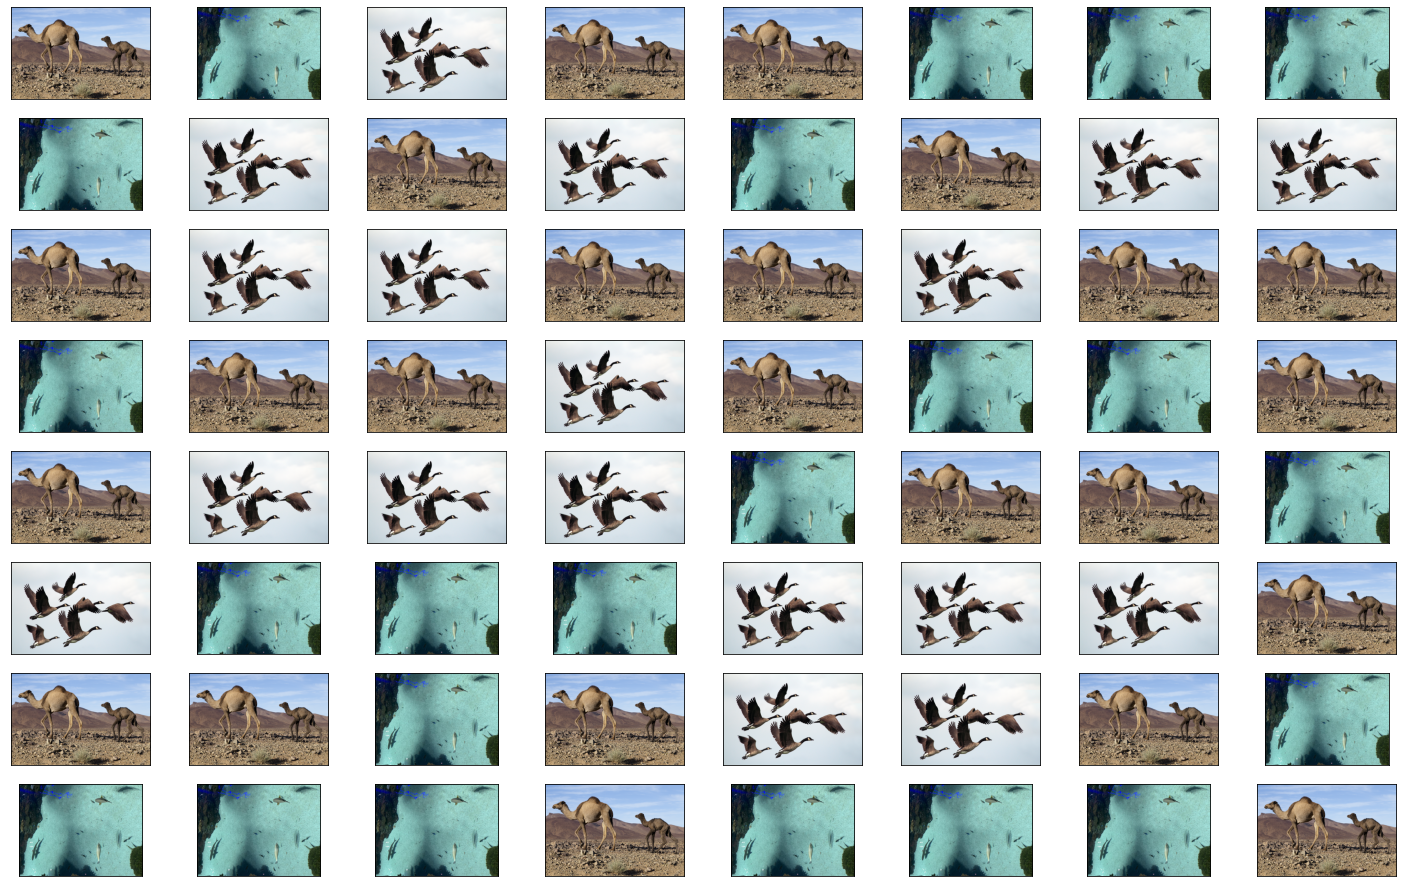

In [4]:
images_to_display = random.choices(images, k=64)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(images_to_display):
    ax = fig.add_subplot(8, 8, ii + 1, xticks=[], yticks=[])
    
    img = Image.open(os.path.join(img_base_path, img))
    plt.imshow(img)

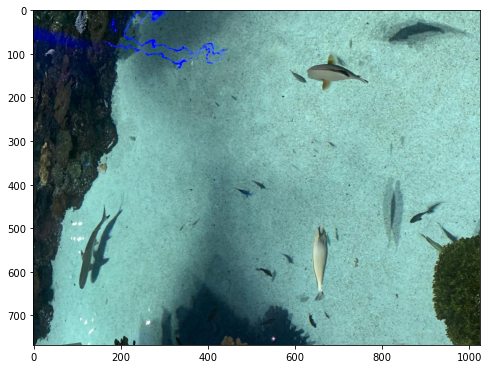

In [5]:
image_name = 'IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e45.jpg'

# read image
img = Image.open(os.path.join(img_base_path, image_name))

# display image
fig = plt.figure(figsize=(8, 12))
plt.imshow(img)

In [62]:
annotation_folders = os.listdir('data')
breed_folder = [x for x in annotation_folders if image_name.split('_')[0] in x]
assert len(breed_folder) == 1, "Multiple Folders Found"

breed_folder = breed_folder[0]
print("Image Folder: ", breed_folder)
annotation_path = os.path.join('../input/annotation/Annotation', breed_folder, image_name[:-4])
print("Annotation Path: ", annotation_path)

AssertionError: Multiple Folders Found

In [6]:
annotation_path = os.path.join('data/annotati.xml' )
print("Annotation Path: ", annotation_path)

Annotation Path:  data/annotati.xml


In [7]:
tree = ET.parse(annotation_path)
root = tree.getroot()
objects = root.findall('object')
for obj in objects:
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
bbox = (xmin, ymin, xmax, ymax)
print("Bounding Box: ", bbox)

Bounding Box:  (93, 442, 189, 641)


In [8]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset

In [66]:
annotation_folders = os.listdir('data')
def ImageLoader(path):
    img = datasets.folder.default_loader(path)
    annotation_path = os.path.join('data/annotati.xml' )
    
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    objects = root.findall('object')
    for obj in objects:
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
    bbox = (xmin, ymin, xmax, ymax)
    
    # return cropped image
    img = img.crop(bbox)
    img = img.resize((64, 64), Image.ANTIALIAS)
    return img

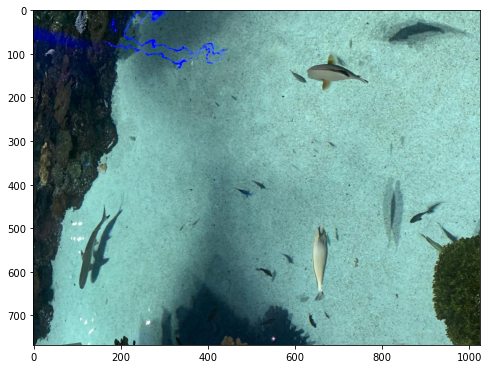

In [9]:
fig = plt.figure(figsize=(8, 12))
plt.imshow(img)

In [10]:
random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]

transform = transforms.Compose([
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# The dataset (example)
dataset = torchvision.datasets.ImageFolder(
    'data/',
    loader=ImageLoader, # THE CUSTOM LOADER
    transform=transform
)

NameError: name 'ImageLoader' is not defined

In [69]:
dataset

Dataset ImageFolder
    Number of datapoints: 3
    Root location: data/
    StandardTransform
Transform: Compose(
               CenterCrop(size=(64, 64))
               RandomHorizontalFlip(p=0.5)
               RandomApply(
               p=0.3
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
           )
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [70]:
od_dataloader = DataLoader(dataset, batch_size=2)

In [71]:
model = torchvision.models.resnet50(pretrained=True)

C:\Users\Vijaykumar Gajbhiye\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Vijaykumar Gajbhiye\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [72]:
req_layers = list(model.children())[:8]


In [73]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from uti import *
from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [74]:
backbone = nn.Sequential(*req_layers)

In [75]:
out = backbone(img_data_all)

In [80]:
for img_batch, gt_bboxes_batch in od_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    
    break
    
img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]


In [81]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [82]:
out_c, out_h, out_w

(2048, 2, 2)

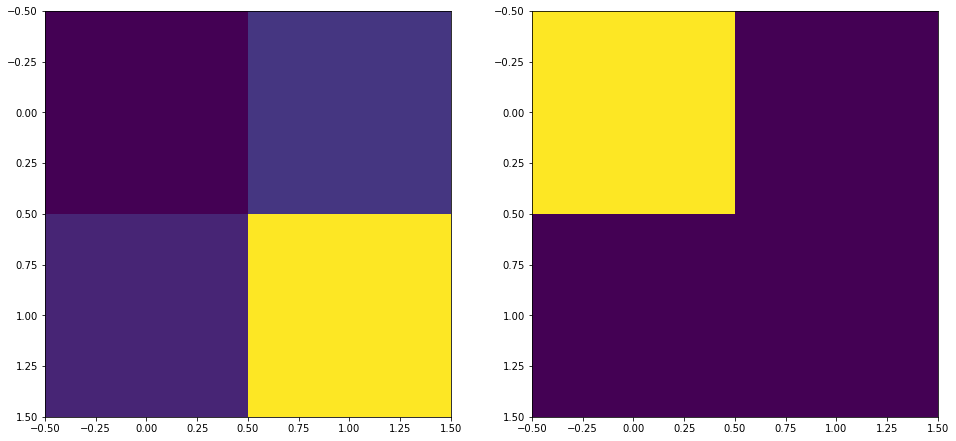

In [79]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data =[filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

In [62]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

NameError: name 'gen_anc_centers' is not defined

In [63]:
import pandas as pd

In [64]:
df = pd.read_csv("train.csv")

In [65]:
df

folder                                           filename  \
0  train  IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e...   
1  train  IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e...   
2  train  IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e...   

                                                path database  width  height  \
0  D:\datasci\aq\train\IMG_8406_jpg.rf.fda4b68f34...  Unknown   1024     768   
1  D:\datasci\aq\train\IMG_8406_jpg.rf.fda4b68f34...  Unknown   1024     768   
2  D:\datasci\aq\train\IMG_8406_jpg.rf.fda4b68f34...  Unknown   1024     768   

   depth  segmented  name         pose  truncated  difficult  xmin  ymin  \
0      3          0  fish  Unspecified          0          0   586    97   
1      3          0  fish  Unspecified          0          0   617   486   
2      3          0  fish  Unspecified          0          0    93   442   

   xmax  ymax  
0   773   187  
1   717   673  
2   189   641

In [66]:
df = df.drop("pose", axis=1)


In [67]:
df = df.drop(["segmented","path", "truncated"], axis =1)

In [68]:
df = df.drop(["folder", "depth","database"], axis =1)

In [69]:
df

filename  width  height  name  \
0  IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e...   1024     768  fish   
1  IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e...   1024     768  fish   
2  IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e...   1024     768  fish   

   difficult  xmin  ymin  xmax  ymax  
0          0   586    97   773   187  
1          0   617   486   717   673  
2          0    93   442   189   641

In [70]:
cols = ["filename","width","height","name","xmin","ymin","xmax","ymax"]
df = df[cols]

In [144]:
df.dtypes

image_id    object
width        int64
height       int64
name        object
xmin         int64
ymin         int64
xmax         int64
ymax         int64
dtype: object

In [73]:
df = df.rename (columns={"filename":"image_id"})

In [95]:
df["image_id"]

0    IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e...
1    IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e...
2    IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e...
Name: image_id, dtype: object

In [107]:
class WheatDataset(Dataset):
    def __init__(self, df, image_dir, transforms = None):
        super().__init__()
        
        self.df = df
        self.image_ids = self.df['image_id'].unique()
        self.image_dir = Path(image_dir)
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]
            
        im_name = image_id 
        img = Image.open(self.image_dir/im_name).convert("RGB")
        img = T.ToTensor()(img)
        
        if self.transforms:
            img = self.transforms(img)
        
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        
        boxes = torch.tensor(boxes, dtype=torch.int64)
        
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        
        return img, target, image_id       
    
    def __len__(self):
        return self.image_ids.shape[0]

In [108]:
train_ds = WheatDataset(train_df, data_path/'train')

In [109]:
image_ids = df['image_id'].unique()
# valid_ids = image_ids[-665:]
train_ids = image_ids[-665:]

In [110]:
train_ids

array(['IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e45.jpg'],
      dtype=object)

In [111]:
train_df = df[df['image_id'].isin(train_ids)]

In [146]:
train_df

image_id  width  height  name  \
0  IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e...   1024     768  fish   
1  IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e...   1024     768  fish   
2  IMG_8406_jpg.rf.fda4b68f345bda8047e7f15060f70e...   1024     768  fish   

   xmin  ymin  xmax  ymax  
0   586    97   773   187  
1   617   486   717   673  
2    93   442   189   641

In [147]:
train_ds = WheatDataset(train_df, data_path/'Images')

In [148]:
data_path = Path('data/')

In [149]:
from pathlib import Path

In [150]:
train_ds

In [151]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [165]:
train_dl = DataLoader(train_ds, batch_size=16, collate_fn=collate_fn)

In [166]:
images, targets, _ = next(iter(train_dl))

In [167]:
targets

({'boxes': tensor([[586,  97, 773, 187],
          [617, 486, 717, 673],
          [ 93, 442, 189, 641]]),
  'labels': tensor([1, 1, 1]),
  'image_id': tensor([0])},)

In [171]:
boxes = targets[0]['boxes']
boxes.shape

torch.Size([3, 4])

In [172]:
boxes[0]

tensor([586,  97, 773, 187])

In [174]:
im = (images[0].permute(1,2,0).numpy() * 255).astype('uint8')
sample = Image.fromarray(im)

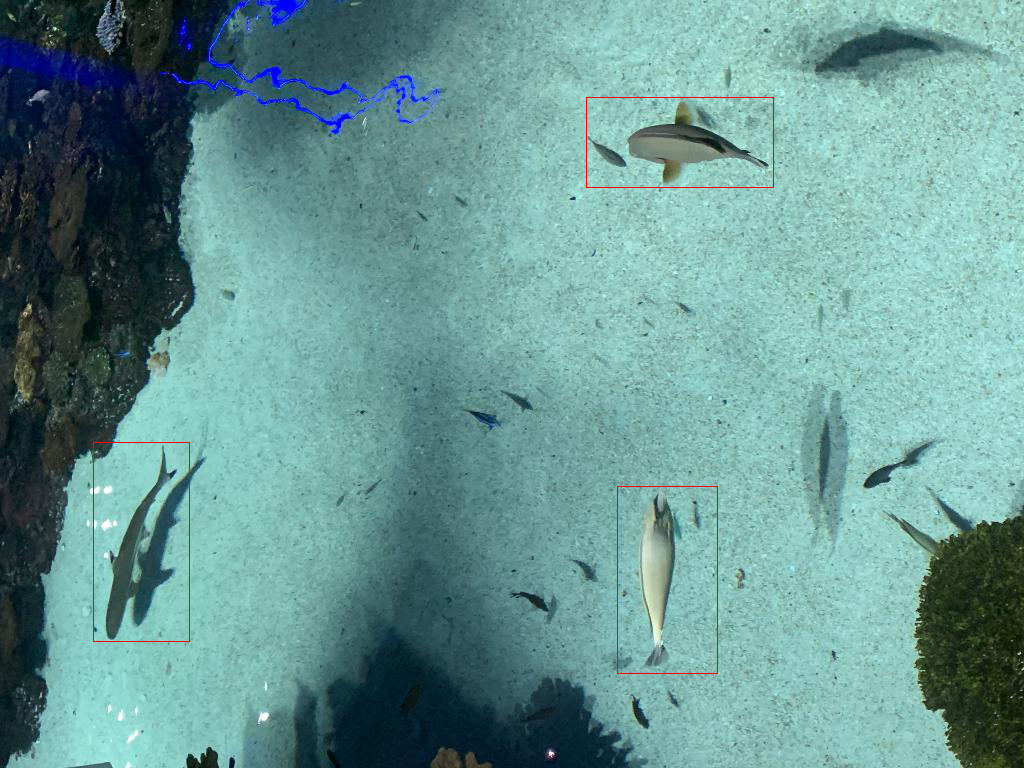

In [177]:
draw = ImageDraw.Draw(sample)
for box in boxes:
    draw.rectangle(box.numpy(), fill = None, outline = "red")
sample

In [176]:
from PIL import Image, ImageDraw


In [179]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 2 # should be initialized as target_col.nunique + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features


In [183]:
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [181]:
import pandas as pd
from pathlib import Path
import ast
import numpy as np
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from matplotlib import pyplot as plt
from typing import Union
import numpy as np

In [182]:
import torchvision.transforms as T


In [184]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [185]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 5

In [186]:
%%time
model.to(device)
for epoch in range(num_epochs):
    epoch_loss = 0
    for images, targets, _ in train_dl:
        optimizer.zero_grad()
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
#         print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        losses.backward()
        optimizer.step()
    print(f"loss for epoch {epoch}: {epoch_loss / len(train_dl)}")

loss for epoch 0: 0.8036020994186401
loss for epoch 1: 0.7381449341773987
loss for epoch 2: 0.6604614853858948
loss for epoch 3: 0.594520628452301
loss for epoch 4: 0.5739446878433228
CPU times: total: 2min 42s
Wall time: 52.1 s


In [189]:
torch.save(model, 'model.pth')

In [194]:
df = pd.read_csv("valid.csv")

In [196]:
df = df.drop("pose", axis=1)
df = df.drop(["segmented","path", "truncated"], axis =1)
df = df.drop(["folder", "depth","database"], axis =1)

In [197]:
df

filename  width  height  name  \
0  IMG_8396_jpg.rf.106a6ced5c649ea81f0de8ecaa4ff3...   1024     768  fish   
1  IMG_8396_jpg.rf.106a6ced5c649ea81f0de8ecaa4ff3...   1024     768  fish   
2  IMG_8396_jpg.rf.106a6ced5c649ea81f0de8ecaa4ff3...   1024     768  fish   
3  IMG_8396_jpg.rf.106a6ced5c649ea81f0de8ecaa4ff3...   1024     768  fish   
4  IMG_8396_jpg.rf.106a6ced5c649ea81f0de8ecaa4ff3...   1024     768  fish   

   difficult  xmin  ymin  xmax  ymax  
0          0   488    16   615   283  
1          0   626   297   750   656  
2          0   508   326   629   641  
3          0   276   298   369   397  
4          0   117   278   319   445

In [198]:
cols = ["filename","width","height","name","xmin","ymin","xmax","ymax"]
df = df[cols]

In [199]:
df = df.rename (columns={"filename":"image_id"})

In [200]:
image_ids = df['image_id'].unique()

In [202]:
valid_ids = image_ids[-665:]

In [203]:
valid_ids

array(['IMG_8396_jpg.rf.106a6ced5c649ea81f0de8ecaa4ff3b8.jpg'],
      dtype=object)

In [204]:
valid_df = df[df['image_id'].isin(valid_ids)]

In [216]:
val_ds = WheatDataset(valid_df, data_path/'test')
val_dl = DataLoader(val_ds, batch_size=8, collate_fn=collate_fn)

In [229]:
results=[]
detection_threshold = 0.05
model.eval()
model.to(device)

for images, targets,idx in val_dl:    

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data
        scores = outputs[i]['scores'].data
        labels = outputs[i]['labels'].data

        keep = torchvision.ops.nms(boxes, scores, 0.3)
        boxes = boxes[keep]
        scores = scores[keep]
        image_id = idx[i]
    
        op = (idx[i], boxes, scores)
        results.append(op)

        break
    break

In [230]:
im_name = image_id 
img = Image.open(data_path/'test'/im_name).convert("RGB")
img = T.ToTensor()(img)

In [231]:
im = (img.permute(1,2,0).detach().numpy() * 255).astype('uint8')
vsample = Image.fromarray(im)

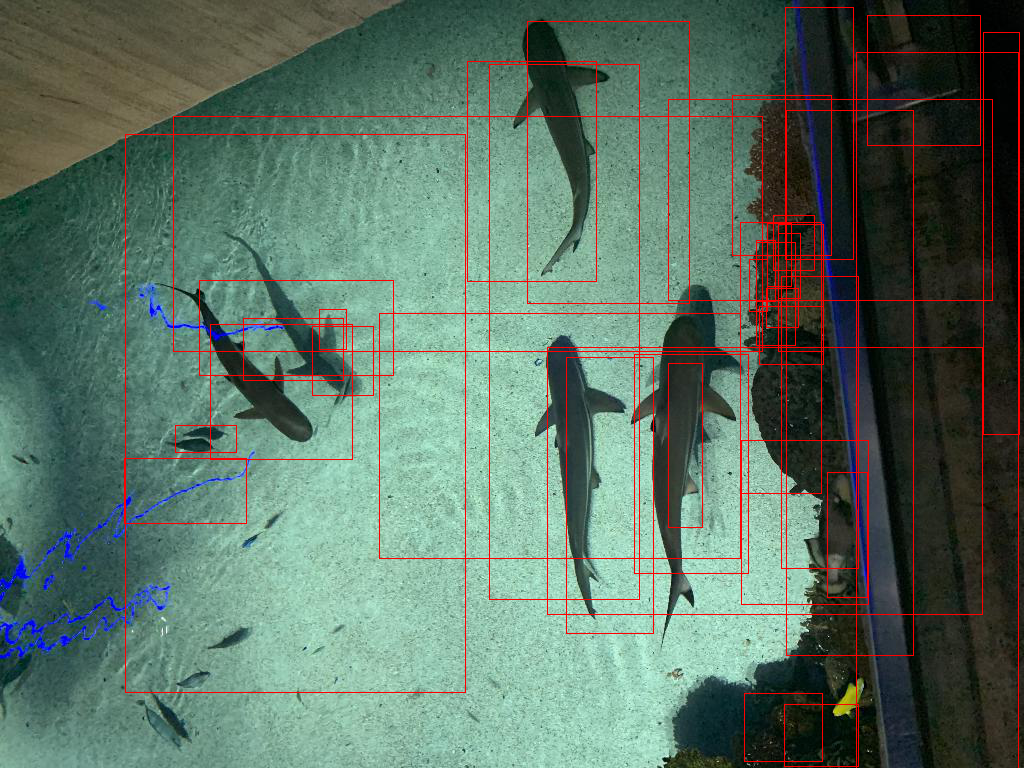

In [232]:
draw = ImageDraw.Draw(vsample)
for box in boxes:
    draw.rectangle(list(box), fill = None, outline = "red")
vsample

In [137]:
images = list(image for image in images)


In [138]:
targets = [{k:v for k, v in t.items()} for t in targets]


AttributeError: 'str' object has no attribute 'items'

In [158]:
output = model(images, targets)

AttributeError: 'str' object has no attribute 'items'

In [22]:
import pickle

In [23]:
with open("model_pickle_faster_rcnn","rb") as f :
    model = pickle.load(f)

In [24]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [25]:
model.eval()
torch.cuda.empty_cache()

In [51]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [44]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [50]:
dataset_path = "Aquarium Combined/"


In [43]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [40]:
import albumentations as A 

In [41]:
import numpy as np
import pandas as pd 
import os
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [42]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A 

In [46]:
from albumentations.pytorch import ToTensorV2

In [48]:
__author__ = 'tylin'
__version__ = '2.0'
# Interface for accessing the Microsoft COCO dataset.

# Microsoft COCO is a large image dataset designed for object detection,
# segmentation, and caption generation. pycocotools is a Python API that
# assists in loading, parsing and visualizing the annotations in COCO.
# Please visit http://mscoco.org/ for more information on COCO, including
# for the data, paper, and tutorials. The exact format of the annotations
# is also described on the COCO website. For example usage of the pycocotools
# please see pycocotools_demo.ipynb. In addition to this API, please download both
# the COCO images and annotations in order to run the demo.

# An alternative to using the API is to load the annotations directly
# into Python dictionary
# Using the API provides additional utility functions. Note that this API
# supports both *instance* and *caption* annotations. In the case of
# captions not all functions are defined (e.g. categories are undefined).

# The following API functions are defined:
#  COCO       - COCO api class that loads COCO annotation file and prepare data structures.
#  decodeMask - Decode binary mask M encoded via run-length encoding.
#  encodeMask - Encode binary mask M using run-length encoding.
#  getAnnIds  - Get ann ids that satisfy given filter conditions.
#  getCatIds  - Get cat ids that satisfy given filter conditions.
#  getImgIds  - Get img ids that satisfy given filter conditions.
#  loadAnns   - Load anns with the specified ids.
#  loadCats   - Load cats with the specified ids.
#  loadImgs   - Load imgs with the specified ids.
#  annToMask  - Convert segmentation in an annotation to binary mask.
#  showAnns   - Display the specified annotations.
#  loadRes    - Load algorithm results and create API for accessing them.
#  download   - Download COCO images from mscoco.org server.
# Throughout the API "ann"=annotation, "cat"=category, and "img"=image.
# Help on each functions can be accessed by: "help COCO>function".

# See also COCO>decodeMask,
# COCO>encodeMask, COCO>getAnnIds, COCO>getCatIds,
# COCO>getImgIds, COCO>loadAnns, COCO>loadCats,
# COCO>loadImgs, COCO>annToMask, COCO>showAnns

# Microsoft COCO Toolbox.      version 2.0
# Data, paper, and tutorials available at:  http://mscoco.org/
# Code written by Piotr Dollar and Tsung-Yi Lin, 2014.
# Licensed under the Simplified BSD License [see bsd.txt]

import json
import time
import numpy as np
import copy
import itertools
# from . import mask as maskUtils
import os
from collections import defaultdict
import sys
PYTHON_VERSION = sys.version_info[0]
if PYTHON_VERSION == 2:
    from urllib import urlretrieve
elif PYTHON_VERSION == 3:
    from urllib.request import urlretrieve


def _isArrayLike(obj):
    return hasattr(obj, '__iter__') and hasattr(obj, '__len__')


class COCO:
    def __init__(self, annotation_file=None):
        """
        Constructor of Microsoft COCO helper class for reading and visualizing annotations.
        :param annotation_file (str): location of annotation file
        :param image_folder (str): location to the folder that hosts images.
        :return:
        """
        # load dataset
        self.dataset,self.anns,self.cats,self.imgs = dict(),dict(),dict(),dict()
        self.imgToAnns, self.catToImgs = defaultdict(list), defaultdict(list)
        if not annotation_file == None:
            print('loading annotations into memory...')
            tic = time.time()
            with open(annotation_file, 'r') as f:
                dataset = json.load(f)
            assert type(dataset)==dict, 'annotation file format {} not supported'.format(type(dataset))
            print('Done (t={:0.2f}s)'.format(time.time()- tic))
            self.dataset = dataset
            self.createIndex()

    def createIndex(self):
        # create index
        print('creating index...')
        anns, cats, imgs = {}, {}, {}
        imgToAnns,catToImgs = defaultdict(list),defaultdict(list)
        if 'annotations' in self.dataset:
            for ann in self.dataset['annotations']:
                imgToAnns[ann['image_id']].append(ann)
                anns[ann['id']] = ann

        if 'images' in self.dataset:
            for img in self.dataset['images']:
                imgs[img['id']] = img

        if 'categories' in self.dataset:
            for cat in self.dataset['categories']:
                cats[cat['id']] = cat

        if 'annotations' in self.dataset and 'categories' in self.dataset:
            for ann in self.dataset['annotations']:
                catToImgs[ann['category_id']].append(ann['image_id'])

        print('index created!')

        # create class members
        self.anns = anns
        self.imgToAnns = imgToAnns
        self.catToImgs = catToImgs
        self.imgs = imgs
        self.cats = cats

    def info(self):
        """
        Print information about the annotation file.
        :return:
        """
        for key, value in self.dataset['info'].items():
            print('{}: {}'.format(key, value))

    def getAnnIds(self, imgIds=[], catIds=[], areaRng=[], iscrowd=None):
        """
        Get ann ids that satisfy given filter conditions. default skips that filter
        :param imgIds  (int array)     : get anns for given imgs
               catIds  (int array)     : get anns for given cats
               areaRng (float array)   : get anns for given area range (e.g. [0 inf])
               iscrowd (boolean)       : get anns for given crowd label (False or True)
        :return: ids (int array)       : integer array of ann ids
        """
        imgIds = imgIds if _isArrayLike(imgIds) else [imgIds]
        catIds = catIds if _isArrayLike(catIds) else [catIds]

        if len(imgIds) == len(catIds) == len(areaRng) == 0:
            anns = self.dataset['annotations']
        else:
            if not len(imgIds) == 0:
                lists = [self.imgToAnns[imgId] for imgId in imgIds if imgId in self.imgToAnns]
                anns = list(itertools.chain.from_iterable(lists))
            else:
                anns = self.dataset['annotations']
            anns = anns if len(catIds)  == 0 else [ann for ann in anns if ann['category_id'] in catIds]
            anns = anns if len(areaRng) == 0 else [ann for ann in anns if ann['area'] > areaRng[0] and ann['area'] < areaRng[1]]
        if not iscrowd == None:
            ids = [ann['id'] for ann in anns if ann['iscrowd'] == iscrowd]
        else:
            ids = [ann['id'] for ann in anns]
        return ids

    def getCatIds(self, catNms=[], supNms=[], catIds=[]):
        """
        filtering parameters. default skips that filter.
        :param catNms (str array)  : get cats for given cat names
        :param supNms (str array)  : get cats for given supercategory names
        :param catIds (int array)  : get cats for given cat ids
        :return: ids (int array)   : integer array of cat ids
        """
        catNms = catNms if _isArrayLike(catNms) else [catNms]
        supNms = supNms if _isArrayLike(supNms) else [supNms]
        catIds = catIds if _isArrayLike(catIds) else [catIds]

        if len(catNms) == len(supNms) == len(catIds) == 0:
            cats = self.dataset['categories']
        else:
            cats = self.dataset['categories']
            cats = cats if len(catNms) == 0 else [cat for cat in cats if cat['name']          in catNms]
            cats = cats if len(supNms) == 0 else [cat for cat in cats if cat['supercategory'] in supNms]
            cats = cats if len(catIds) == 0 else [cat for cat in cats if cat['id']            in catIds]
        ids = [cat['id'] for cat in cats]
        return ids

    def getImgIds(self, imgIds=[], catIds=[]):
        '''
        Get img ids that satisfy given filter conditions.
        :param imgIds (int array) : get imgs for given ids
        :param catIds (int array) : get imgs with all given cats
        :return: ids (int array)  : integer array of img ids
        '''
        imgIds = imgIds if _isArrayLike(imgIds) else [imgIds]
        catIds = catIds if _isArrayLike(catIds) else [catIds]

        if len(imgIds) == len(catIds) == 0:
            ids = self.imgs.keys()
        else:
            ids = set(imgIds)
            for i, catId in enumerate(catIds):
                if i == 0 and len(ids) == 0:
                    ids = set(self.catToImgs[catId])
                else:
                    ids &= set(self.catToImgs[catId])
        return list(ids)

    def loadAnns(self, ids=[]):
        """
        Load anns with the specified ids.
        :param ids (int array)       : integer ids specifying anns
        :return: anns (object array) : loaded ann objects
        """
        if _isArrayLike(ids):
            return [self.anns[id] for id in ids]
        elif type(ids) == int:
            return [self.anns[ids]]

    def loadCats(self, ids=[]):
        """
        Load cats with the specified ids.
        :param ids (int array)       : integer ids specifying cats
        :return: cats (object array) : loaded cat objects
        """
        if _isArrayLike(ids):
            return [self.cats[id] for id in ids]
        elif type(ids) == int:
            return [self.cats[ids]]

    def loadImgs(self, ids=[]):
        """
        Load anns with the specified ids.
        :param ids (int array)       : integer ids specifying img
        :return: imgs (object array) : loaded img objects
        """
        if _isArrayLike(ids):
            return [self.imgs[id] for id in ids]
        elif type(ids) == int:
            return [self.imgs[ids]]

    def showAnns(self, anns, draw_bbox=False):
        """
        Display the specified annotations.
        :param anns (array of object): annotations to display
        :return: None
        """
        if len(anns) == 0:
            return 0
        if 'segmentation' in anns[0] or 'keypoints' in anns[0]:
            datasetType = 'instances'
        elif 'caption' in anns[0]:
            datasetType = 'captions'
        else:
            raise Exception('datasetType not supported')
        if datasetType == 'instances':
            import matplotlib.pyplot as plt
            from matplotlib.collections import PatchCollection
            from matplotlib.patches import Polygon

            ax = plt.gca()
            ax.set_autoscale_on(False)
            polygons = []
            color = []
            for ann in anns:
                c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
                if 'segmentation' in ann:
                    if type(ann['segmentation']) == list:
                        # polygon
                        for seg in ann['segmentation']:
                            poly = np.array(seg).reshape((int(len(seg)/2), 2))
                            polygons.append(Polygon(poly))
                            color.append(c)
                    else:
                        # mask
                        t = self.imgs[ann['image_id']]
                        if type(ann['segmentation']['counts']) == list:
                            rle = maskUtils.frPyObjects([ann['segmentation']], t['height'], t['width'])
                        else:
                            rle = [ann['segmentation']]
                        m = maskUtils.decode(rle)
                        img = np.ones( (m.shape[0], m.shape[1], 3) )
                        if ann['iscrowd'] == 1:
                            color_mask = np.array([2.0,166.0,101.0])/255
                        if ann['iscrowd'] == 0:
                            color_mask = np.random.random((1, 3)).tolist()[0]
                        for i in range(3):
                            img[:,:,i] = color_mask[i]
                        ax.imshow(np.dstack( (img, m*0.5) ))
                if 'keypoints' in ann and type(ann['keypoints']) == list:
                    # turn skeleton into zero-based index
                    sks = np.array(self.loadCats(ann['category_id'])[0]['skeleton'])-1
                    kp = np.array(ann['keypoints'])
                    x = kp[0::3]
                    y = kp[1::3]
                    v = kp[2::3]
                    for sk in sks:
                        if np.all(v[sk]>0):
                            plt.plot(x[sk],y[sk], linewidth=3, color=c)
                    plt.plot(x[v>0], y[v>0],'o',markersize=8, markerfacecolor=c, markeredgecolor='k',markeredgewidth=2)
                    plt.plot(x[v>1], y[v>1],'o',markersize=8, markerfacecolor=c, markeredgecolor=c, markeredgewidth=2)

                if draw_bbox:
                    [bbox_x, bbox_y, bbox_w, bbox_h] = ann['bbox']
                    poly = [[bbox_x, bbox_y], [bbox_x, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y]]
                    np_poly = np.array(poly).reshape((4,2))
                    polygons.append(Polygon(np_poly))
                    color.append(c)

            p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)
        elif datasetType == 'captions':
            for ann in anns:
                print(ann['caption'])

    def loadRes(self, resFile):
        """
        Load result file and return a result api object.
        :param   resFile (str)     : file name of result file
        :return: res (obj)         : result api object
        """
        res = COCO()
        res.dataset['images'] = [img for img in self.dataset['images']]

        print('Loading and preparing results...')
        tic = time.time()
        if type(resFile) == str or (PYTHON_VERSION == 2 and type(resFile) == unicode):
            with open(resFile) as f:
                anns = json.load(f)
        elif type(resFile) == np.ndarray:
            anns = self.loadNumpyAnnotations(resFile)
        else:
            anns = resFile
        assert type(anns) == list, 'results in not an array of objects'
        annsImgIds = [ann['image_id'] for ann in anns]
        assert set(annsImgIds) == (set(annsImgIds) & set(self.getImgIds())), \
               'Results do not correspond to current coco set'
        if 'caption' in anns[0]:
            imgIds = set([img['id'] for img in res.dataset['images']]) & set([ann['image_id'] for ann in anns])
            res.dataset['images'] = [img for img in res.dataset['images'] if img['id'] in imgIds]
            for id, ann in enumerate(anns):
                ann['id'] = id+1
        elif 'bbox' in anns[0] and not anns[0]['bbox'] == []:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                bb = ann['bbox']
                x1, x2, y1, y2 = [bb[0], bb[0]+bb[2], bb[1], bb[1]+bb[3]]
                if not 'segmentation' in ann:
                    ann['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]
                ann['area'] = bb[2]*bb[3]
                ann['id'] = id+1
                ann['iscrowd'] = 0
        elif 'segmentation' in anns[0]:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                # now only support compressed RLE format as segmentation results
                ann['area'] = maskUtils.area(ann['segmentation'])
                if not 'bbox' in ann:
                    ann['bbox'] = maskUtils.toBbox(ann['segmentation'])
                ann['id'] = id+1
                ann['iscrowd'] = 0
        elif 'keypoints' in anns[0]:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                s = ann['keypoints']
                x = s[0::3]
                y = s[1::3]
                x0,x1,y0,y1 = np.min(x), np.max(x), np.min(y), np.max(y)
                ann['area'] = (x1-x0)*(y1-y0)
                ann['id'] = id + 1
                ann['bbox'] = [x0,y0,x1-x0,y1-y0]
        print('DONE (t={:0.2f}s)'.format(time.time()- tic))

        res.dataset['annotations'] = anns
        res.createIndex()
        return res

    def download(self, tarDir = None, imgIds = [] ):
        '''
        Download COCO images from mscoco.org server.
        :param tarDir (str): COCO results directory name
               imgIds (list): images to be downloaded
        :return:
        '''
        if tarDir is None:
            print('Please specify target directory')
            return -1
        if len(imgIds) == 0:
            imgs = self.imgs.values()
        else:
            imgs = self.loadImgs(imgIds)
        N = len(imgs)
        if not os.path.exists(tarDir):
            os.makedirs(tarDir)
        for i, img in enumerate(imgs):
            tic = time.time()
            fname = os.path.join(tarDir, img['file_name'])
            if not os.path.exists(fname):
                urlretrieve(img['coco_url'], fname)
            print('downloaded {}/{} images (t={:0.1f}s)'.format(i, N, time.time()- tic))

    def loadNumpyAnnotations(self, data):
        """
        Convert result data from a numpy array [Nx7] where each row contains {imageID,x1,y1,w,h,score,class}
        :param  data (numpy.ndarray)
        :return: annotations (python nested list)
        """
        print('Converting ndarray to lists...')
        assert(type(data) == np.ndarray)
        print(data.shape)
        assert(data.shape[1] == 7)
        N = data.shape[0]
        ann = []
        for i in range(N):
            if i % 1000000 == 0:
                print('{}/{}'.format(i,N))
            ann += [{
                'image_id'  : int(data[i, 0]),
                'bbox'  : [ data[i, 1], data[i, 2], data[i, 3], data[i, 4] ],
                'score' : data[i, 5],
                'category_id': int(data[i, 6]),
                }]
        return ann

    def annToRLE(self, ann):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        t = self.imgs[ann['image_id']]
        h, w = t['height'], t['width']
        segm = ann['segmentation']
        if type(segm) == list:
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, h, w)
            rle = maskUtils.merge(rles)
        elif type(segm['counts']) == list:
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, h, w)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann)
        m = maskUtils.decode(rle)
        return m


In [54]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [53]:
device = torch.device("cpu")

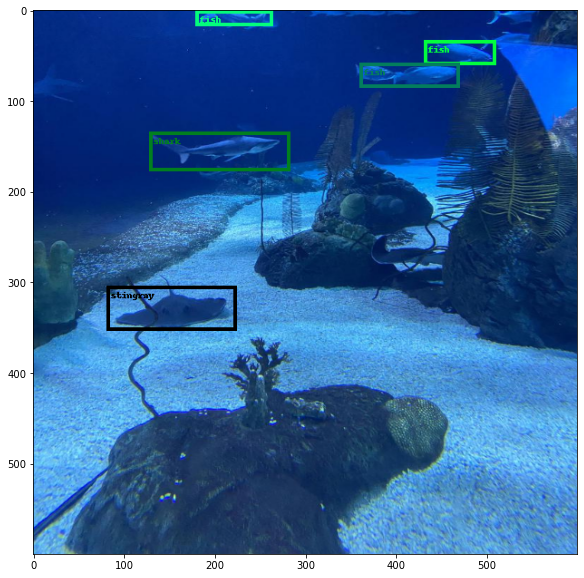

In [61]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [60]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [59]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}